# The goal of this Note Book
Validate the effectiveness of ResNet and its residual connections comparing the two, a regular neural network and ResNet, for CIFAR-10.  
- VGG 19  
- Regular neural network  
- ResNet-34 & ResNet-50  

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf. config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data
### 1.1 Data download
kaggle competitions download -c dogs-vs-cats  
unzip -qq dogs-vs-cats.zip  
unzip -qq train.zip  

In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")

In [8]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = original_dir / subset_name / category
        
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                 for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

In [9]:
make_subset("train", start_index=0, end_index=8000)
make_subset("validation", start_index=8000, end_index=10000)
make_subset("test", start_index=10000, end_index=12000)

## 1.2 Data Normalization
- Resize to (224, 224)  
- uint8` -> `float32  

In [13]:
from tensorflow.keras.utils import image_dataset_from_directory


# Generates a tf.data.Dataset from image files in a directory.
# Read image file and transform to RGB file
# cast dt to tf.float
# Resize tensor input size
# Configure Batch size
train_dataset = image_dataset_from_directory(
    original_dir / "train",
    image_size=(224, 224),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    original_dir / "test",
    image_size=(224, 224),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    original_dir / "validation",
    image_size=(224, 224),
    batch_size=32
)

train_dataset = train_dataset.map(lambda x, y: (x / 255, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255, y))
validation_dataset = validation_dataset.map(lambda x, y: (x / 255, y))

Found 16000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.


## 2. Model
### 2.1 Build ResNet, Regular, VGG Block
- Consider the reusability of the block

In [87]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, Dense, AveragePooling2D, MaxPooling2D, Flatten

# Resnet Block
def resnet_block(x, is_50=False, is_first_block = False, num_cnn=3, channel=64, block_num=1):
    shortcut = x
    if is_50:         
        for cnn_num in range(num_cnn):
            # is_first_block = True 
            if cnn_num == 0 and is_first_block:
                x = Conv2D(filters=channel,
                           kernel_size=(1,1),
                           kernel_initializer='he_normal',
                           padding='same',
                           name=f'block{block_num}_conv{cnn_num * 10 + 1}')(x)
                shortcut = Conv2D(channel*4, kernel_size=(1, 1), strides=1, padding="same")(shortcut)
                shortcut = BatchNormalization()(shortcut)
                
            # cnn_num == 0 && is_first_block = False
            elif cnn_num == 0 and not is_first_block:
                x = Conv2D(filters=channel,
                           kernel_size=(3,3),
                           strides=2,
                           kernel_initializer='he_normal',
                           padding='same',
                           name=f'block{block_num}_conv{cnn_num * 10 + 1}')(x)
                shortcut = Conv2D(channel*4, kernel_size=(1, 1), strides=2, padding="same")(shortcut)
                shortcut = BatchNormalization()(shortcut)
                
            # is_first_block = False AND cnn_num!=0
            else:
                x = Conv2D(filters=channel,
                           kernel_size=(1,1),
                           kernel_initializer='he_normal',
                           name=f'block{block_num}_conv{cnn_num * 10 + 1}')(x)
                
            x = BatchNormalization(name=f'block{block_num}_bn{cnn_num * 10 + 2}')(x)
            x = Activation('relu',name=f'block{block_num}_act{cnn_num * 10 + 3}')(x)
            x = Conv2D(filters=channel,
                       kernel_size=(3,3),
                       kernel_initializer='he_normal',
                       padding='same',
                       name=f'block{block_num}_conv{cnn_num * 10 + 2}')(x)
            x = BatchNormalization(name=f'block{block_num}_bn{cnn_num * 10 + 4}')(x)
            x = Activation('relu',name=f'block{block_num}_act{cnn_num * 10 + 5}')(x)
            
            x = Conv2D(filters=channel*4,
                       kernel_size=(1,1),
                       kernel_initializer='he_normal',
                       name=f'block{block_num}_conv{cnn_num * 10 + 6}')(x)
            x = BatchNormalization(name=f'block{block_num}_bn{cnn_num * 10 + 7}')(x)
            x = Add()([x, shortcut])
            x = Activation('relu',name=f'block{block_num}_act{cnn_num * 10 + 8}')(x)
            
    else:
        for cnn_num in range(num_cnn):
            # is_first_block = True 
            if cnn_num == 0 and is_first_block:
                x = Conv2D(filters=channel,
                           kernel_size=(3,3),
                           kernel_initializer='he_normal',
                           padding='same',
                           name=f'block{block_num}_conv{cnn_num * 2 + 1}')(x)
                
            # cnn_num == 0 && is_first_block = False
            elif cnn_num == 0 and not is_first_block:
                x = Conv2D(filters=channel,
                           kernel_size=(3,3),
                           strides=2,
                           kernel_initializer='he_normal',
                           padding='same',
                           name=f'block{block_num}_conv{cnn_num * 2 + 1}')(x)
                shortcut = Conv2D(channel, kernel_size=(1, 1), strides=2, padding="same")(shortcut)
                shortcut = BatchNormalization()(shortcut)
                
            # is_first_block = False AND cnn_num!=0
            else:
                x = Conv2D(filters=channel,
                           kernel_size=(3,3),
                           kernel_initializer='he_normal',
                           padding='same',
                           name=f'block{block_num}_conv{cnn_num * 2 + 1}')(x)
                
            x = BatchNormalization(name=f'block{block_num}_bn{cnn_num * 2 + 1}')(x)
            x = Activation('relu',name=f'block{block_num}_act{cnn_num * 2 + 1}')(x)
            x = Conv2D(filters=channel,
                       kernel_size=(3,3),
                       kernel_initializer='he_normal',
                       padding='same',
                       name=f'block{block_num}_conv{cnn_num * 2 + 2}')(x)
            x = BatchNormalization(name=f'block{block_num}_bn{cnn_num * 2 + 2}')(x)
            x = Add()([x, shortcut])
            x = Activation('relu',name=f'block{block_num}_act{cnn_num * 2 + 2}')(x) 
          
    return x

In [80]:
# Default Model: ResNet-34 for cats_vs_dogs dataset
def build_resnet(input_shape=(224,224,3),
                 is_50=False,
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=1):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    output = Conv2D(filters=64,
                    kernel_size=(7,7),
                    strides=2,
                    padding="same",
                    name="conv1_conv"
                    )(output)
    
    output = BatchNormalization(name="conv1_bn")(output)
    output = Activation('relu', 
                        name="conv1_relu")(output)
    
    output = MaxPooling2D(3,
                          strides=2,
                          padding="same", 
                          name="pool1_pool")(output)
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        if i == 0:
            output = resnet_block(output,
                                  is_50,
                                  is_first_block=True,
                                  num_cnn=num_cnn,
                                  channel=channel,
                                  block_num=i+2)
        else: 
            output = resnet_block(output,
                                  is_50,
                                  is_first_block=False,
                                  num_cnn=num_cnn,
                                  channel=channel,
                                  block_num=i+2)
        
    output = AveragePooling2D(pool_size=(1, 1), name="avg_pool")(output)
    output = Flatten()(output)
    output = Dense(num_classes,
                   activation="sigmoid",
                   name="predictions")(output)
    
    model = keras.Model(inputs=input_layer,
                        outputs=output)
    
    return model

In [85]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False)
resnet_34.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        input_24[0][0]                   
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 112, 112, 64) 0           conv1_bn[0][0]                   
___________________________________________________________________________________________

In [97]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)
resnet_50.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        input_30[0][0]                   
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 112, 112, 64) 0           conv1_bn[0][0]                   
___________________________________________________________________________________________

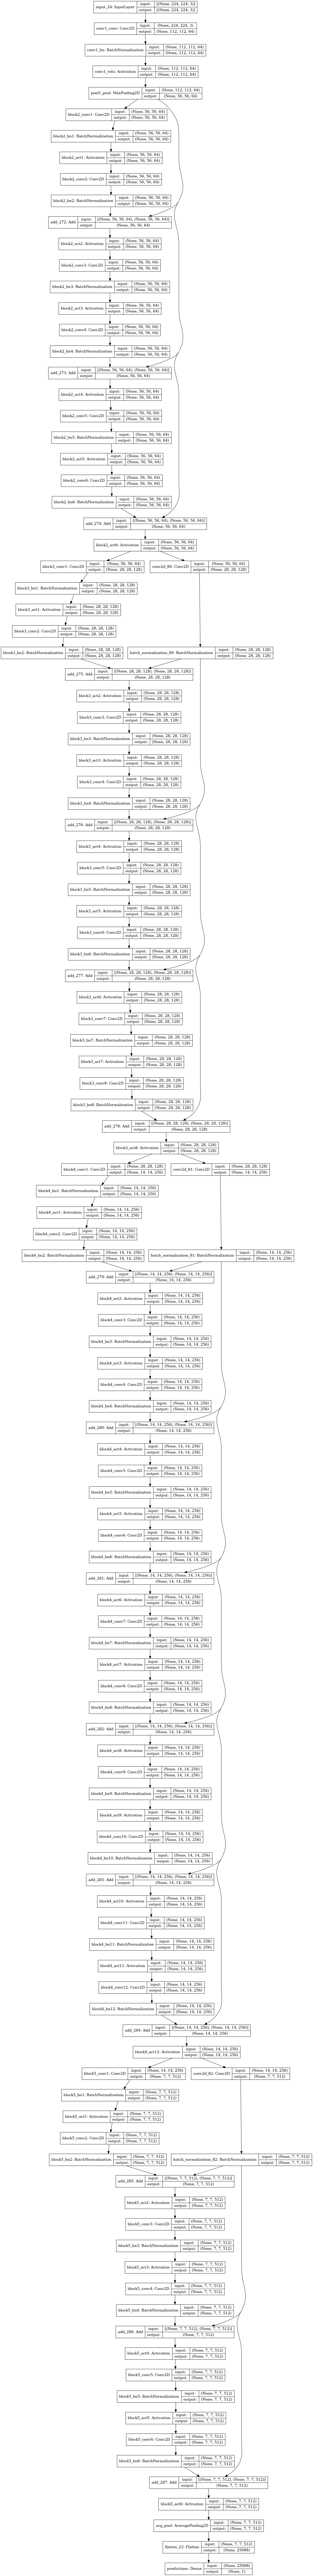

In [98]:
tf.keras.utils.plot_model(resnet_34, to_file='./resnet_34.png', show_shapes=True)

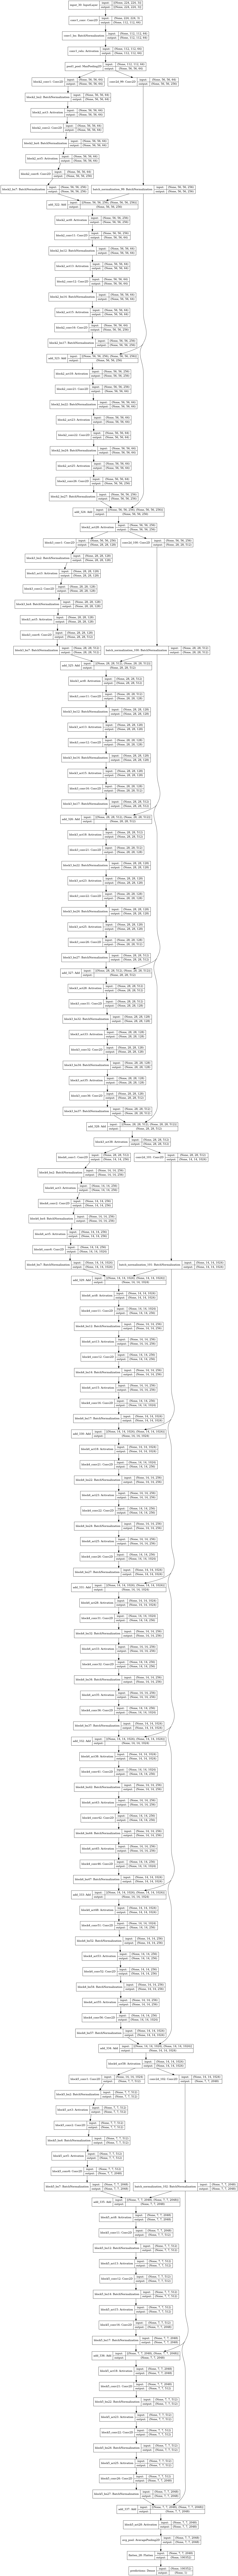

In [99]:
tf.keras.utils.plot_model(resnet_50, to_file='./resnet_50.png', show_shapes=True)

In [33]:
from keras.callbacks import ModelCheckpoint
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'],
)

In [34]:
model_checkpoint = ModelCheckpoint(
    filepath="resnet_34.keras",
    save_best_only=True,
    monitor="val_loss"
)

history_34 = resnet_34.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=model_checkpoint,
)


Epoch 1/15
500/500 [==============================] - 134s 201ms/step - loss: 0.9616 - accuracy: 0.5900 - val_loss: 0.6843 - val_accuracy: 0.6047


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/15
500/500 [==============================] - 100s 200ms/step - loss: 0.6042 - accuracy: 0.6775 - val_loss: 1.1148 - val_accuracy: 0.6090
Epoch 3/15
500/500 [==============================] - 100s 200ms/step - loss: 0.5533 - accuracy: 0.7217 - val_loss: 1.6353 - val_accuracy: 0.5755
Epoch 4/15
500/500 [==============================] - 100s 200ms/step - loss: 0.5098 - accuracy: 0.7534 - val_loss: 0.7969 - val_accuracy: 0.6488
Epoch 5/15
500/500 [==============================] - 100s 200ms/step - loss: 0.4676 - accuracy: 0.7828 - val_loss: 0.5510 - val_accuracy: 0.7203
Epoch 6/15
500/500 [==============================] - 100s 201ms/step - loss: 0.4124 - accuracy: 0.8137 - val_loss: 0.5897 - val_accuracy: 0.7015
Epoch 7/15
500/500 [==============================] - 100s 200ms/step - loss: 0.3558 - accuracy: 0.8436 - val_loss: 0.6819 - val_accuracy: 0.7165
Epoch 8/15
500/500 [==============================] - 100s 200ms/step - loss: 0.3091 - accuracy: 0.8676 - val_loss: 0.5248 -

In [36]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_34_dict = history_34.history
# Save it under the form of a json file
json.dump(history_34_dict, open("history_34_dict", 'w'))

In [100]:
from keras.callbacks import ModelCheckpoint
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'],
)
model_checkpoint = ModelCheckpoint(
    filepath="resnet_50.keras",
    save_best_only=True,
    monitor="val_loss"
)

history_resnet_50 = resnet_50.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=model_checkpoint,
)

history_50_dict = history_resnet_50.history
# Save it under the form of a json file
json.dump(history_50_dict, open("history_50_dict", 'w'))


Epoch 1/15
500/500 [==============================] - 222s 425ms/step - loss: 1.4282 - accuracy: 0.5686 - val_loss: 74.8438 - val_accuracy: 0.5163


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/15
500/500 [==============================] - 211s 421ms/step - loss: 0.6551 - accuracy: 0.6472 - val_loss: 1.0072 - val_accuracy: 0.5242
Epoch 3/15
500/500 [==============================] - 210s 420ms/step - loss: 0.6526 - accuracy: 0.6874 - val_loss: 0.6210 - val_accuracy: 0.6575
Epoch 4/15
500/500 [==============================] - 210s 420ms/step - loss: 0.5979 - accuracy: 0.7229 - val_loss: 0.8132 - val_accuracy: 0.5527
Epoch 5/15
500/500 [==============================] - 210s 420ms/step - loss: 0.5441 - accuracy: 0.7442 - val_loss: 2.0194 - val_accuracy: 0.6647
Epoch 6/15
500/500 [==============================] - 210s 419ms/step - loss: 0.5279 - accuracy: 0.7622 - val_loss: 1.0143 - val_accuracy: 0.6963
Epoch 7/15
500/500 [==============================] - 210s 419ms/step - loss: 0.5103 - accuracy: 0.7749 - val_loss: 1.5337 - val_accuracy: 0.6348
Epoch 8/15
500/500 [==============================] - 210s 420ms/step - loss: 0.4578 - accuracy: 0.7993 - val_loss: 7.6478 -

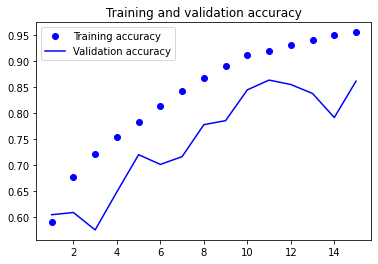

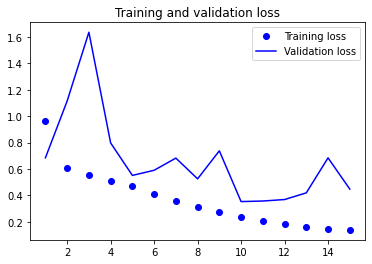

In [37]:
import matplotlib.pyplot as plt

accuracy_34 = history_34.history["accuracy"]
val_accuracy_34 = history_34.history["val_accuracy"]
loss_34 = history_34.history["loss"]
val_loss_34 = history_34.history["val_loss"]

accuracy_50 = history_50.history["accuracy"]
val_accuracy_50 = history_50.history["val_accuracy"]
loss_50 = history_50.history["loss"]
val_loss_50 = history_50.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy_34, "bo", label="ResNet34 Training accuracy")
plt.plot(epochs, val_accuracy_34, "b", label="ResNet34 Validation accuracy")
plt.plot(epochs, accuracy_50, "ro", label="ResNet34 Training accuracy")
plt.plot(epochs, val_accuracy_50, "r", label="ResNet34 Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss_34, "bo", label="ResNet34 Training loss")
plt.plot(epochs, val_loss_34, "b", label="ResNet34 Validation loss")
plt.plot(epochs, loss_50, "ro", label="ResNet34 Training loss")
plt.plot(epochs, val_loss_50, "r", label="ResNet34 Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()



In [91]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, Dense, AveragePooling2D, MaxPooling2D, Flatten

# Regular
def regular_block(x, is_50=False, is_first_block = False, num_cnn=3, channel=64, block_num=1):
    shortcut = x
    if is_50:         
        for cnn_num in range(num_cnn):
            # is_first_block = True 
            if cnn_num == 0 and is_first_block:
                x = Conv2D(filters=channel,
                           kernel_size=(1,1),
                           kernel_initializer='he_normal',
                           padding='same',
                           name=f'block{block_num}_conv{cnn_num * 10 + 1}')(x)
                shortcut = Conv2D(channel*4, kernel_size=(1, 1), strides=1, padding="same")(shortcut)
                shortcut = BatchNormalization()(shortcut)
                
            # cnn_num == 0 && is_first_block = False
            elif cnn_num == 0 and not is_first_block:
                x = Conv2D(filters=channel,
                           kernel_size=(3,3),
                           strides=2,
                           kernel_initializer='he_normal',
                           padding='same',
                           name=f'block{block_num}_conv{cnn_num * 10 + 1}')(x)
                shortcut = Conv2D(channel*4, kernel_size=(1, 1), strides=2, padding="same")(shortcut)
                shortcut = BatchNormalization()(shortcut)
                
            # is_first_block = False AND cnn_num!=0
            else:
                x = Conv2D(filters=channel,
                           kernel_size=(1,1),
                           kernel_initializer='he_normal',
                           padding='same',
                           name=f'block{block_num}_conv{cnn_num * 10 + 1}')(x)
                
            x = BatchNormalization(name=f'block{block_num}_bn{cnn_num * 10 + 2}')(x)
            x = Activation('relu',name=f'block{block_num}_act{cnn_num * 10 + 3}')(x)
            x = Conv2D(filters=channel,
                       kernel_size=(3,3),
                       kernel_initializer='he_normal',
                       padding='same',
                       name=f'block{block_num}_conv{cnn_num * 10 + 2}')(x)
            x = BatchNormalization(name=f'block{block_num}_bn{cnn_num * 10 + 4}')(x)
            x = Activation('relu',name=f'block{block_num}_act{cnn_num * 10 + 5}')(x)
            
            x = Conv2D(filters=channel*4,
                       kernel_size=(1,1),
                       kernel_initializer='he_normal',
                       name=f'block{block_num}_conv{cnn_num * 10 + 6}')(x)
            x = BatchNormalization(name=f'block{block_num}_bn{cnn_num * 10 + 7}')(x)
            x = Activation('relu',name=f'block{block_num}_act{cnn_num * 10 + 8}')(x)
            
    else:
        for cnn_num in range(num_cnn):
            # is_first_block = True 
            if cnn_num == 0 and is_first_block:
                x = Conv2D(filters=channel,
                           kernel_size=(3,3),
                           kernel_initializer='he_normal',
                           padding='same',
                           name=f'block{block_num}_conv{cnn_num * 2 + 1}')(x)
                
            # cnn_num == 0 && is_first_block = False
            elif cnn_num == 0 and not is_first_block:
                x = Conv2D(filters=channel,
                           kernel_size=(3,3),
                           strides=2,
                           kernel_initializer='he_normal',
                           padding='same',
                           name=f'block{block_num}_conv{cnn_num * 2 + 1}')(x)
                shortcut = Conv2D(channel, kernel_size=(1, 1), strides=2, padding="same")(shortcut)
                shortcut = BatchNormalization()(shortcut)
        
                
            x = BatchNormalization(name=f'block{block_num}_bn{cnn_num * 2 + 1}')(x)
            x = Activation('relu',name=f'block{block_num}_act{cnn_num * 2 + 1}')(x)
            x = Conv2D(filters=channel,
                       kernel_size=(3,3),
                       kernel_initializer='he_normal',
                       padding='same',
                       name=f'block{block_num}_conv{cnn_num * 2 + 2}')(x)
            x = BatchNormalization(name=f'block{block_num}_bn{cnn_num * 2 + 2}')(x)
            x = Activation('relu',name=f'block{block_num}_act{cnn_num * 2 + 2}')(x) 
          
    return x

In [92]:
# Default Model: ResNet-34 for cats_vs_dogs dataset
def build_regular_net(input_shape=(224,224,3),
                     is_50=False,
                     num_cnn_list=[3,4,6,3],
                     channel_list=[64,128,256,512],
                     num_classes=1):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    output = Conv2D(filters=64,
                    kernel_size=(7,7),
                    strides=2,
                    padding="same",
                    name="conv1_conv"
                    )(output)
    
    output = BatchNormalization(name="conv1_bn")(output)
    output = Activation('relu', 
                        name="conv1_relu")(output)
    
    output = MaxPooling2D(3,
                          strides=2,
                          padding="same", 
                          name="pool1_pool")(output)
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        if i == 0:
            output = regular_block(output,
                                  is_50,
                                  is_first_block=True,
                                  num_cnn=num_cnn,
                                  channel=channel,
                                  block_num=i+2)
        else: 
            output = regular_block(output,
                                  is_50,
                                  is_first_block=False,
                                  num_cnn=num_cnn,
                                  channel=channel,
                                  block_num=i+2)
        
    output = AveragePooling2D(pool_size=(1, 1), name="avg_pool")(output)
    output = Flatten()(output)
    output = Dense(num_classes,
                   activation="sigmoid",
                   name="predictions")(output)
    
    model = keras.Model(inputs=input_layer,
                        outputs=output)
    
    return model

In [93]:
regular_34 = build_regular_net(input_shape=(224, 224, 3), is_50=False)
regular_34.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
pool1_pool (MaxPooling2D)    (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block2_bn1 (BatchNormalizati (None, 56, 56, 64)        256

In [94]:
regular_50 = build_regular_net(input_shape=(224, 224, 3), is_50=True)
regular_50.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
pool1_pool (MaxPooling2D)    (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 64)        4160      
_________________________________________________________________
block2_bn2 (BatchNormalizati (None, 56, 56, 64)        256

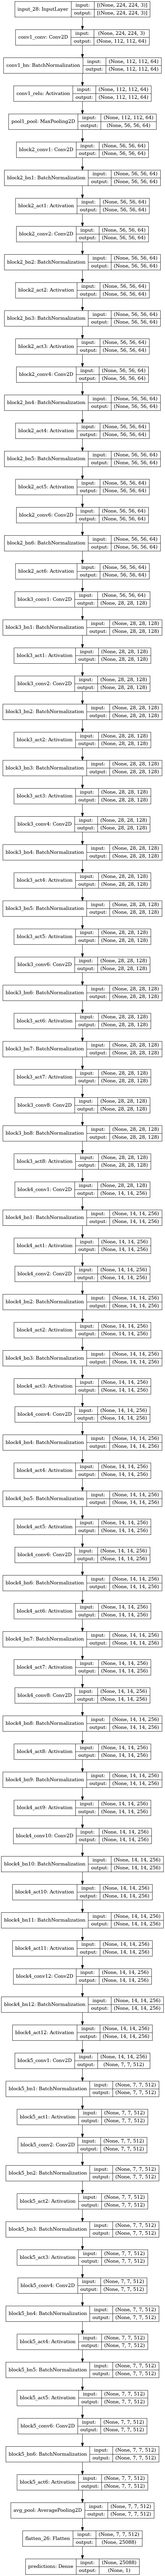

In [95]:
tf.keras.utils.plot_model(regular_34, to_file='./regular_34.png', show_shapes=True)

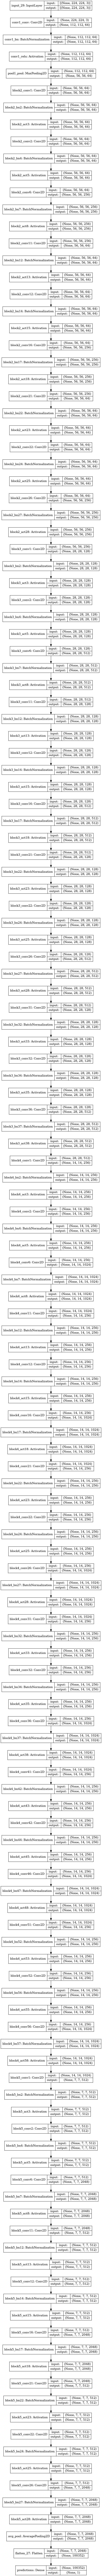

In [96]:
tf.keras.utils.plot_model(regular_50, to_file='./regular_50.png', show_shapes=True)

In [62]:
from keras.callbacks import ModelCheckpoint
regular_34.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'],
)
model_checkpoint = ModelCheckpoint(
    filepath="regular_34.keras",
    save_best_only=True,
    monitor="val_loss"
)

history_reg_34 = regular_34.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=model_checkpoint,
)

history_reg_34_dict = history_reg_34.history
# Save it under the form of a json file
json.dump(history_reg_34_dict, open("history_reg_34_dict", 'w'))

Epoch 1/15
500/500 [==============================] - 76s 143ms/step - loss: 0.9362 - accuracy: 0.5132 - val_loss: 1.7044 - val_accuracy: 0.4978
Epoch 2/15
500/500 [==============================] - 71s 141ms/step - loss: 0.6938 - accuracy: 0.5452 - val_loss: 2.2602 - val_accuracy: 0.5145
Epoch 3/15
500/500 [==============================] - 70s 140ms/step - loss: 0.6694 - accuracy: 0.5985 - val_loss: 0.6785 - val_accuracy: 0.5518
Epoch 4/15
500/500 [==============================] - 70s 140ms/step - loss: 0.6365 - accuracy: 0.6434 - val_loss: 0.6635 - val_accuracy: 0.6112
Epoch 5/15
500/500 [==============================] - 71s 141ms/step - loss: 0.5928 - accuracy: 0.6860 - val_loss: 0.6326 - val_accuracy: 0.6578
Epoch 6/15
500/500 [==============================] - 70s 140ms/step - loss: 0.5592 - accuracy: 0.7191 - val_loss: 0.6915 - val_accuracy: 0.6275
Epoch 7/15
500/500 [==============================] - 70s 140ms/step - loss: 0.5112 - accuracy: 0.7556 - val_loss: 0.5106 - val_ac

In [101]:
from keras.callbacks import ModelCheckpoint
regular_50.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'],
)
model_checkpoint = ModelCheckpoint(
    filepath="regular_50.keras",
    save_best_only=True,
    monitor="val_loss"
)

history_reg_50 = regular_50.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=model_checkpoint,
)

history_reg_50_dict = history_reg_50.history
# Save it under the form of a json file
json.dump(history_reg_50_dict, open("history_reg_50_dict", 'w'))

Epoch 1/15
500/500 [==============================] - 191s 364ms/step - loss: 1.6180 - accuracy: 0.5089 - val_loss: 0.7273 - val_accuracy: 0.5000
Epoch 2/15
500/500 [==============================] - 181s 361ms/step - loss: 0.8540 - accuracy: 0.5100 - val_loss: 0.7193 - val_accuracy: 0.5005
Epoch 3/15
500/500 [==============================] - 181s 361ms/step - loss: 0.7048 - accuracy: 0.5016 - val_loss: 2.5642 - val_accuracy: 0.5000
Epoch 4/15
500/500 [==============================] - 180s 359ms/step - loss: 0.7476 - accuracy: 0.5070 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 5/15
500/500 [==============================] - 180s 359ms/step - loss: 0.6953 - accuracy: 0.5139 - val_loss: 0.7029 - val_accuracy: 0.4820
Epoch 6/15
500/500 [==============================] - 179s 359ms/step - loss: 0.7410 - accuracy: 0.5070 - val_loss: 0.7048 - val_accuracy: 0.4880
Epoch 7/15
500/500 [==============================] - 179s 358ms/step - loss: 0.6934 - accuracy: 0.5157 - val_loss: 0.6935 -

## 3. Ablation Study
Validate the effectiveness of ResNet and its residual connections comparing the two, a regular neural network and ResNet, for CIFAR-10.

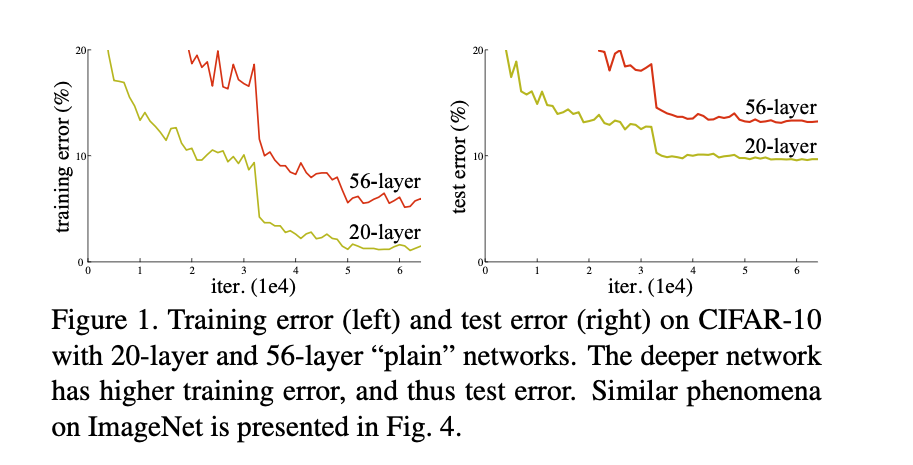

| Model               | Total Params( Trainable params) | test-loss | test-accuracy |
|---------------------|---------------------------------|-----------|---------------|
| Resnet(layer - 34)  | 21,335,297(21,318,273)          | 0.367     | 0.845         |
| Resnet(layer - 50)  | 29,193,089(29,139,969)          | 0.611     | 0.799         |
| Regular(layer - 34) | 12,972,161(12,956,929)          | 0.350     | 0.845         |
| Regular(layer - 50) | 26,404,993(26,359,553)          | 0.694     | 0.493         |

### 3.1 Compare test dataset accuracy & loss

In [102]:
test_model = keras.models.load_model(
    "resnet_34.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

125/125 [==============================] - 8s 61ms/step - loss: 0.3673 - accuracy: 0.8445
Test Accuracy: 0.845
Test loss: 0.367


In [103]:
test_model = keras.models.load_model(
    "resnet_50.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

125/125 [==============================] - 15s 109ms/step - loss: 0.6106 - accuracy: 0.7995
Test Accuracy: 0.799
Test loss: 0.611


In [104]:
test_model = keras.models.load_model(
    "regular_34.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

125/125 [==============================] - 6s 41ms/step - loss: 0.3496 - accuracy: 0.8447
Test Accuracy: 0.845
Test loss: 0.350


In [105]:
test_model = keras.models.load_model(
    "regular_50.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

125/125 [==============================] - 13s 95ms/step - loss: 0.6940 - accuracy: 0.4935
Test Accuracy: 0.493
Test loss: 0.694


### 3.2 Compare ResNet34 & ResNet50 || Reg34 & ResNet50

In [121]:
# Load the JSON data from the file
with open("history_reg34_dict", "r") as file:
    history_reg34 = json.load(file)
    
with open("history_reg50_dict", "r") as file:
    history_reg50 = json.load(file)
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

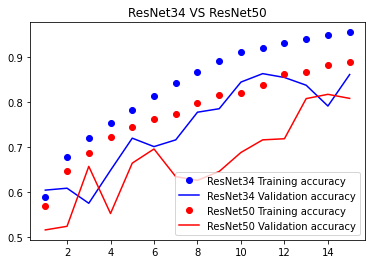

<Figure size 432x288 with 0 Axes>

In [123]:
import matplotlib.pyplot as plt
import json
# Load the JSON data from the file
with open("history_resnet34_dict", "r") as file:
    history_res34 = json.load(file)
    
with open("history_resnet50_dict", "r") as file:
    history_res50 = json.load(file)
import matplotlib.pyplot as plt

accuracy_res34 = history_res34["accuracy"]
val_accuracy_res34 = history_res34["val_accuracy"]
loss_res34 = history_res34["loss"]
val_loss_res34 = history_res34["val_loss"]

accuracy_res50 = history_res50["accuracy"]
val_accuracy_res50 = history_res50["val_accuracy"]
loss_res50 = history_res50["loss"]
val_loss_res50 = history_res50["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy_res34, "bo", label="ResNet34 Training accuracy")
plt.plot(epochs, val_accuracy_res34, "b", label="ResNet34 Validation accuracy")
plt.plot(epochs, accuracy_res50, "ro", label="ResNet50 Training accuracy")
plt.plot(epochs, val_accuracy_res50, "r", label="ResNet50 Validation accuracy")
plt.title("ResNet34 VS ResNet50")
plt.legend()
plt.figure()

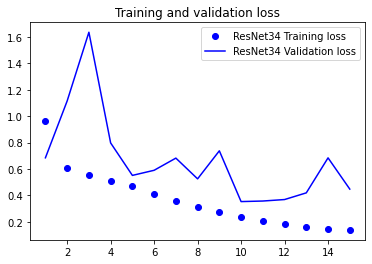

In [111]:
plt.plot(epochs, loss_res34, "bo", label="ResNet34 Training loss")
plt.plot(epochs, val_loss_res34, "b", label="ResNet34 Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

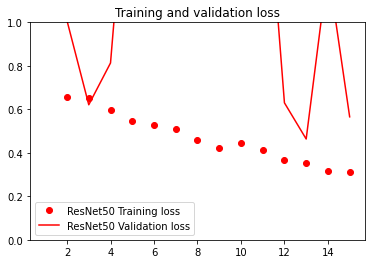

In [112]:
plt.plot(epochs, loss_res50, "ro", label="ResNet50 Training loss")
plt.plot(epochs, val_loss_res50, "r", label="ResNet50 Validation loss")
plt.title("Training and validation loss")
plt.legend()
# Set the y-axis limits to 0 to 5
plt.ylim(0, 1)
plt.show()

<Figure size 432x288 with 0 Axes>

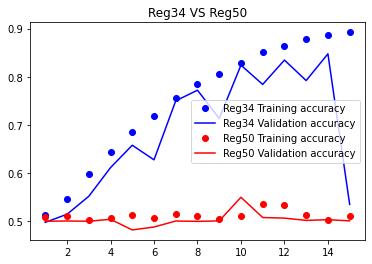

<Figure size 432x288 with 0 Axes>

In [122]:
accuracy_reg34 = history_reg34["accuracy"]
val_accuracy_reg34 = history_reg34["val_accuracy"]
loss_reg34 = history_reg34["loss"]
val_loss_reg34 = history_reg34["val_loss"]

accuracy_reg50 = history_reg50["accuracy"]
val_accuracy_reg50 = history_reg50["val_accuracy"]
loss_reg50 = history_reg50["loss"]
val_loss_reg50 = history_reg50["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy_reg34, "bo", label="Reg34 Training accuracy")
plt.plot(epochs, val_accuracy_reg34, "b", label="Reg34 Validation accuracy")
plt.plot(epochs, accuracy_reg50, "ro", label="Reg50 Training accuracy")
plt.plot(epochs, val_accuracy_reg50, "r", label="Reg50 Validation accuracy")
plt.title("Reg34 VS Reg50")
plt.legend()
plt.figure()

#### Point: 깊은 층을 가진 모델 -> 성능 더 안 좋아

### 3.3 Compare with Regular 34 & 50

<Figure size 432x288 with 0 Axes>

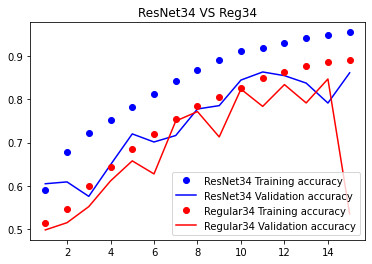

<Figure size 432x288 with 0 Axes>

In [118]:
accuracy_res34 = history_res34["accuracy"]
val_accuracy_res34 = history_res34["val_accuracy"]
loss_res34 = history_res34["loss"]
val_loss_res34 = history_res34["val_loss"]

accuracy_reg34 = history_reg34["accuracy"]
val_accuracy_reg34 = history_reg34["val_accuracy"]
loss_reg34 = history_reg34["loss"]
val_loss_reg34 = history_reg34["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy_res34, "bo", label="ResNet34 Training accuracy")
plt.plot(epochs, val_accuracy_res34, "b", label="ResNet34 Validation accuracy")
plt.plot(epochs, accuracy_reg34, "ro", label="Regular34 Training accuracy")
plt.plot(epochs, val_accuracy_reg34, "r", label="Regular34 Validation accuracy")
plt.title("ResNet34 VS Reg34")
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

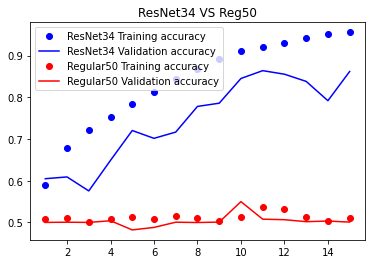

<Figure size 432x288 with 0 Axes>

In [120]:
accuracy_res34 = history_res34["accuracy"]
val_accuracy_res34 = history_res34["val_accuracy"]
loss_res34 = history_res34["loss"]
val_loss_res34 = history_res34["val_loss"]

accuracy_reg50 = history_reg50["accuracy"]
val_accuracy_reg50 = history_reg50["val_accuracy"]
loss_reg50 = history_reg50["loss"]
val_loss_reg50 = history_reg50["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy_res34, "bo", label="ResNet34 Training accuracy")
plt.plot(epochs, val_accuracy_res34, "b", label="ResNet34 Validation accuracy")
plt.plot(epochs, accuracy_reg50, "ro", label="Regular50 Training accuracy")
plt.plot(epochs, val_accuracy_reg50, "r", label="Regular50 Validation accuracy")
plt.title("ResNet34 VS Reg50")
plt.legend()
plt.figure()